## data set checks

In [6]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"d:\DTD\Project\Dataset\Final data transfromed dataset.csv")

# Remove unwanted index columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Check if Total_Spend matches the sum of individual spends
df['Total_Check'] = df['R&D_Spend'] + df['Administration'] + df['Marketing_Spend']

# Compare Total_Spend vs computed sum
mismatch_count = (df['Total_Spend'] != df['Total_Check']).sum()

print(f"Number of rows where Total_Spend does NOT equal the sum of R&D, Administration, Marketing: {mismatch_count}")

# Optional: see the first few mismatches
print(df[df['Total_Spend'] != df['Total_Check']][['R&D_Spend', 'Administration', 'Marketing_Spend', 'Total_Spend', 'Total_Check']].head())


Number of rows where Total_Spend does NOT equal the sum of R&D, Administration, Marketing: 317
    R&D_Spend  Administration  Marketing_Spend  Total_Spend  Total_Check
1   162597.70       151377.59        443898.53    757873.82    757873.82
6   134615.46       147198.87        127716.82    409531.15    409531.15
9   123334.88       108679.17        304981.62    536995.67    536995.67
14  119943.24       156547.42        256512.92    533003.58    533003.58
15  114523.61       122616.84        261776.23    498916.68    498916.68


### add r&d and marketing

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv(r"d:\DTD\Project\Dataset\Final data transfromed dataset.csv")

# Remove unwanted index columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Create a new column: total of R&D and Marketing spend
df['R&D_Marketing_Spend'] = df['R&D_Spend'] + df['Marketing_Spend']

# Optional: scale it
scaler = StandardScaler()
df['R&D_Marketing_Spend_scaled'] = scaler.fit_transform(df[['R&D_Marketing_Spend']])

# Save back to CSV (overwrite or new file)
df.to_csv(r"d:\DTD\Project\Dataset\Final data transfromed dataset.csv", index=False)

print("New column added and CSV saved successfully!")


New column added and CSV saved successfully!


### pca analysis

Explained variance per component:
 [0.31141421 0.30250736 0.29507724 0.09100119 0.        ]

Cumulative variance:
 [0.31141421 0.61392156 0.90899881 1.         1.        ]


C:\Users\reshm\AppData\Local\Temp\ipykernel_29216\3019097187.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["State_California", "State_Florida", "State_New York"]] = X[["State_California", "State_Florida", "State_New York"]].astype(int)


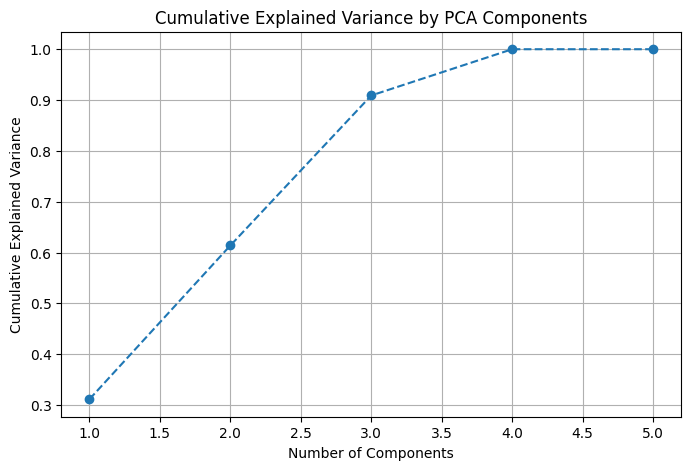


Feature loadings for each principal component:
                                  PC1       PC2       PC3       PC4  \
Administration_scaled       0.635862 -0.071669 -0.303477 -0.706007   
R&D_Marketing_Spend_scaled  0.646743 -0.112672 -0.263043  0.706992   
State_California            0.072225  0.803868 -0.098008  0.025575   
State_Florida               0.255900 -0.351933  0.693820 -0.032038   
State_New York             -0.326654 -0.460551 -0.589677  0.006025   

                                     PC5  
Administration_scaled      -1.841410e-18  
R&D_Marketing_Spend_scaled -1.552320e-17  
State_California            5.816523e-01  
State_Florida               5.729274e-01  
State_New York              5.774381e-01  


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------------------------
# 1. Load dataset
# ----------------------------------------------
df = pd.read_csv(r"d:\DTD\Project\Dataset\Final data transfromed dataset.csv")

# Remove unwanted index columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# ----------------------------------------------
# 2. Select features for PCA
# Include all features you want to test, including states
# ----------------------------------------------
features = [
    "Administration_scaled",
    "R&D_Marketing_Spend_scaled",
    # "ROI_scaled",  # optional, but keep in mind it's derived from Profit
    "State_California",
    "State_Florida",
    "State_New York"
]

X = df[features]

# Convert boolean dummies to int
X[["State_California", "State_Florida", "State_New York"]] = X[["State_California", "State_Florida", "State_New York"]].astype(int)

# ----------------------------------------------
# 3. Standardize features
# PCA works best with standardized data
# ----------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------------------------
# 4. Apply PCA
# ----------------------------------------------
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# ----------------------------------------------
# 5. Explained variance ratio
# ----------------------------------------------
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained variance per component:\n", explained_variance)
print("\nCumulative variance:\n", cumulative_variance)

# Plot cumulative variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# ----------------------------------------------
# 6. Feature contribution (loadings)
# ----------------------------------------------
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features))], index=features)
print("\nFeature loadings for each principal component:\n", loadings)


### Modelling - final

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------------------------
# 1. Load dataset
# ----------------------------------------------
df = pd.read_csv(
    "d:\DTD\Project\Dataset\Final data transfromed dataset.csv"
)

# ----------------------------------------------
# 2. Remove unwanted index columns
# ----------------------------------------------
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# ----------------------------------------------
# 3. Define target
# ----------------------------------------------
y = df["Profit"]

# ----------------------------------------------
# 4. Select ONLY valid predictors
#    (Scaled variables + State dummies)
# ----------------------------------------------
X = df[
    [
        # "R&D_Spend_scaled",
        "Administration_scaled",
        # "Marketing_Spend_scaled",
        # "Total_Spend_scaled",
        "R&D_Marketing_Spend_scaled",
        # "ROI_scaled",
        "State_California",
        "State_Florida",
        "State_New York"
    ]
]

# Convert boolean dummies to int
X[["State_California", "State_Florida", "State_New York"]] = (
    X[["State_California", "State_Florida", "State_New York"]].astype(int)
)

# ----------------------------------------------
# 5. Drop missing values (safe step)
# ----------------------------------------------
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns="Profit")
y = data["Profit"]

# ----------------------------------------------
# 6. Train-Test Split
# ----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------------------------
# 7. Fit OLS regression
# ----------------------------------------------
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

# ----------------------------------------------
# 8. Model Evaluation
# ----------------------------------------------
y_pred = model.predict(X_test_sm)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nRMSE:", rmse)
print("R²:", r2)

# ----------------------------------------------
# 9. Feature importance (clean interpretation)
# ----------------------------------------------
coef_table = (
    pd.DataFrame({
        "Feature": model.params.index,
        "Coefficient": model.params.values,
        "AbsCoeff": np.abs(model.params.values)
    })
    .sort_values("AbsCoeff", ascending=False)
)

print("\nFeature Importance:\n", coef_table)

# ----------------------------------------------
# 10. Multicollinearity check (VIF)
# ----------------------------------------------
vif = pd.DataFrame()
vif["Feature"] = X_train.columns
vif["VIF"] = [
    variance_inflation_factor(X_train.values, i)
    for i in range(X_train.shape[1])
]

print("\nVIF Table (should be < 5):\n", vif)


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     3807.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:18:23   Log-Likelihood:                -8493.1
No. Observations:                 794   AIC:                         1.699e+04
Df Residuals:                     790   BIC:                         1.701e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.936e+04    285.988  

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
C:\Users\reshm\AppData\Local\Temp\ipykernel_29216\1019153779.py:12: SyntaxWarning: invalid escape sequence '\D'
  "d:\DTD\Project\Dataset\Final data transfromed dataset.csv"
C:\Users\reshm\AppData\Local\Temp\ipykernel_29216\1019153779.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["State_California", "State_Florida", "State_New York"]] = (
